<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/03/Assignment_03_Companion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 Companion Notebook: Analysis of Data from a Sensor Network to Determine Room Occupancy

A [wireless sensor network](https://en.wikipedia.org/wiki/Wireless_sensor_network) consists of a bunch of sensors (e.g., light meters, barometers, microphones, cameras) that send data throughout a network.  Oftentimes, the sensor data is aggregated on a central server where algorithms may be running to make sense of what's happening in the environment.  While this sounds an awful lot like surveillance (and it is), the data can also be used for other purposes.  For instance, we may be able to optimize energy usage in a building if we know whether particular rooms are occupied (e.g., by adjusting climate control systems).  It may be difficult to design a system to process the raw sensor data and convert it into actionable information (such as the occupancy of various rooms).  A machine learning model can help by automatically extracting such information after being trained on an appropriate training set.

As a quick example of this sort of problem, we downloaded the [occupancy detection dataset](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+) from the UCI Machine Learning repository (if you're interested, you can read about the [original analysis of the data](https://www.sciencedirect.com/science/article/pii/S0378778815304357)).  The dataset consists of 20,560 data instances each with the following information:

* date time year-month-day hour:minute:second*
* Temperature, in Celsius
* Relative Humidity, %
* Light, in Lux
* CO2, in ppm
* Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
* Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

## Predicting Occupancy (Examining Single Variables)

In this example, we're going to see if we can predict whether there is someone in the room (occupancy) using the data above.

To get started, we'll read the data and create some plots that show the values that some of the features take on when the occupancy is either 0 or 1.

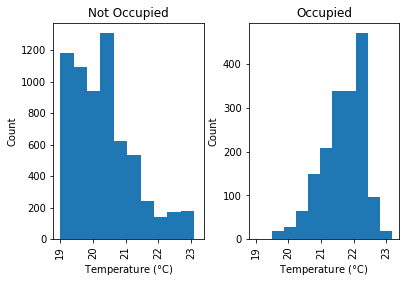

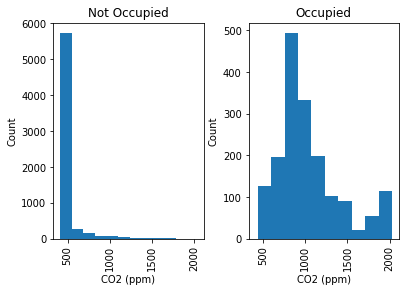

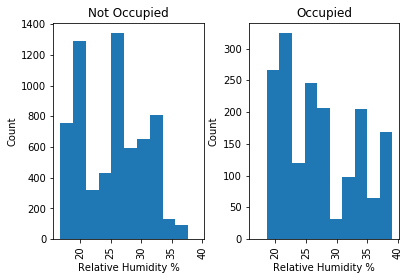

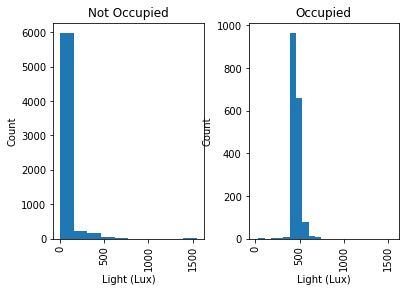

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1DX5L9-e7I5B18RW2-DFTORhk4O27WyR0')
# For simplicity we'll just look at these four columns
df = df[['CO2','Light', 'Humidity', 'Temperature', 'Occupancy']]


def make_dual_histogram(df, column, xlabel):
    subplots = df.hist(by='Occupancy', column = column, sharex=True)
    [subplot.set_xlabel(xlabel) for subplot in subplots]
    [subplot.set_ylabel('Count') for subplot in subplots]
    subplots[0].set_title('Not Occupied')
    subplots[1].set_title('Occupied')
    plt.show()

make_dual_histogram(df, 'Temperature', 'Temperature ($\degree$C)')
make_dual_histogram(df, 'CO2', 'CO2 (ppm)')
make_dual_histogram(df, 'Humidity', 'Relative Humidity %')
make_dual_histogram(df, 'Light', 'Light (Lux)')

### *Notebook Exercise 1 (15 minutes)*

The plots shown above are known as histograms.  They specify the count of the number of times a value in a particular range was seen in the dataset.  The histograms in the left column correspond to the case where *the room was not* occupied and those on the right correspond to the case where *the room was* occupied.  For example, if you look at the bottom row of plots, they tell us that were about $1,000$ instances where the room was occupied and the light value was just below $5,000$.  In contrast, there were only about $100$ instances where the light value was just below $5,000$.

Based on the plots above, which of these features looks like it will be useful for building a model to determine when the room is occupied?  Are there any features that look like they will not be very useful? Justify your answers.

#### *Expand for Solution*

***Solution***

Light looks like a very good indicator of occupancy of the room (observe that the light value seldom goes near $5,000$ unless the room is occupied.  Temperature also looks to be a pretty good indicator of occupancy (warmer temperatures seem to be correlated with the room being occupied).  CO2 also looks pretty good for reasons similar to those already outlined for other predictors.  Humidity doesn't seem to be all that useful of an indicator since the two histograms look relatively similar.

## Predicting Occupancy With Logistic Regression

Now that we've looked at the variables one-by-one (always a good idea), we're going to use logistic regression to create a predictor for occupancy that considers multiple variables. As a first cut, let's try to create a model that considers two of the independent variables we examined previously.  We'll start out by looking at using temperature and light to predict occupancy.

Before we actually fit the model, we'll create a scatter plot so you can see how the occupancy status varies across both light and temperature.

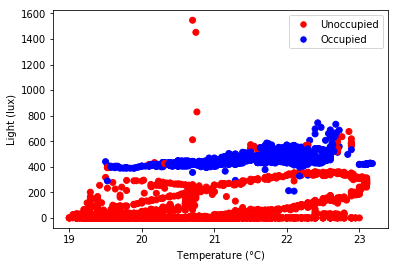

In [2]:
from matplotlib.lines import Line2D

plt.scatter(df['Temperature'], df['Light'], c=df['Occupancy'].map(lambda x: 'b' if x else 'r'))
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Light (lux)')

custom_lines = [Line2D([0], [0], marker='.', label='Unoccupied',
                       markerfacecolor='r', color='w', markersize=15),
                Line2D([0], [0], marker='.', label='Occupied',
                       markerfacecolor='b', color='w', markersize=15)]

plt.legend(custom_lines, ['Unoccupied', 'Occupied'])

plt.show()

Recall that logistic regression models the probability of the output being 1 (which in our problem corresponds to the room being occupied) as:

$$\sigma(\mathbf{w}^\top \mathbf{x}) = \frac{1}{1 + e^{-\mathbf{w}^\top \mathbf{x}}}$$

If we think of $\mathbf{x}$ as consisting of $x_1 = \mbox{temperature}$, $x_2 = \mbox{light}$, and $x_3 = 1$ (the feature with value $1$ allows us to compute a bias) then the equation becomes:


$$\sigma(\mathbf{w}^\top \mathbf{x}) = \frac{1}{1 + e^{-(w_1 \times \mbox{temperature} + w_2 \times \mbox{light} + w_3 )}}$$

In order to determine $\mathbf{w}$ we will be using the logistic regression algorithm.  Later in the assignment document we will precisely define the objective that is optimized by the logistic regression algorithm.  Here, we can simply think of logistic regression as trying to find a line that best divides the blue points from the red points in the figure above.  For now, we'll use an off-the-shelf implementation of logistic regression that is built into scikit learn.

The output shows the learned weights $(w_1, w_2, w_3)$ along with the accuracy of the model on both a training and a test set (50% of the data was used for training and 50% was used for test).

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def fit_model(columns_to_use):
    # Note: this is might not really be a fair way to do a training / testing split
    # since it will result in instances that were very close in time falling in
    # both the training and testing set
    X_train, X_test, y_train, y_test = \
        train_test_split(df[columns_to_use], df['Occupancy'])

    model = LogisticRegression()
    model.fit(X_train, y_train)
    for i, c in enumerate(columns_to_use):
        print('w_%d (the weight for %s) = %f' % (i+1, c, model.coef_[0, i]))
    
    print('w_%d (the weight for the bias term) = %f' % (len(columns_to_use) + 1, model.intercept_[0]))

    print('Accuracy on training set', (model.predict(X_train) == y_train).mean())
    print('Accuracy on testing set', (model.predict(X_test) == y_test).mean())
    return model

fit_model(['Temperature', 'Light']);

w_1 (the weight for Temperature) = -0.479172
w_2 (the weight for Light) = 0.028925
w_3 (the weight for the bias term) = -0.020471
Accuracy on training set 0.9888652366137219
Accuracy on testing set 0.9852652259332023


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### *Notebook Exercise 2 (20 minutes)*

(a) Interpret the values for the fitted weights $w_1$ and $w_2$ ($w_3$ is tricky to interpret in the way we are currently using the data.  When we talk about normalization, you'll learn how to interpret the bias term).  What do they mean interms of how the model would make predictions on new data?

(b) For a given temperature, $temp$, and light value, $l$, what would the model say is the probability of the room being occupied.

(c) Try different combinations of features.  In terms of accuracy, what seems to be the best model?

#### *Expand for Solution*

***Solution***

(a) The weight $w_1$ demonstrates that as temperature goes up, the probability of occupancy goes down.  The weight $w_2$ also shows that as the light value goes up, the probability of occupancy goes up.

(b) 

Note: your numbers won't match exactly due to randomness in the train / test split.

$$p(\mbox{occupancy}) = \frac{1}{1 + e^{-(-0.44 \times \mbox{temp} + 0.027 \times \mbox{light} -0.019)}}$$

(c) Most any feature and light seems to do about the same in terms of performance.  Adding all of the features may do slightly better, but it's tough to tell (you'll learn more precise ways of figuring this out later in this module).  If you don't include light the performance goes down dramatically.  Using just light is slightly worse than light with another feature.

## Predicting Occupancy (Visualizing the Model)

To put a cap on this example, we're now going to visualize the model predictions as a function of the model inputs.  This visualization should further reinforce how logistic regression maps from inputs to the probability of the output being 1.  The visualization shows the probabilities (represented as a heat map) for various temperature / light combinations.  Shown for convenience is the data used to create the model.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


w_1 (the weight for Temperature) = -0.418298
w_2 (the weight for Light) = 0.025461
w_3 (the weight for the bias term) = -0.018220
Accuracy on training set 0.9869002783690847
Accuracy on testing set 0.9911591355599214


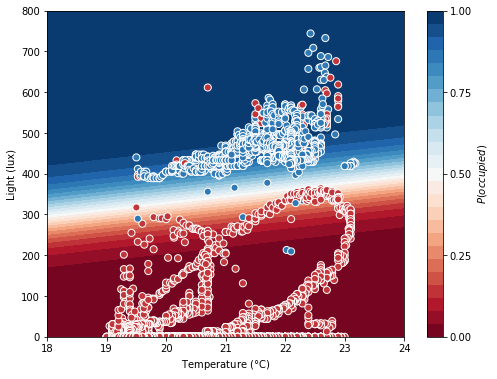

In [10]:
import numpy as np

model = fit_model(['Temperature', 'Light']);

xx, yy = np.mgrid[18:24:.01, 0:800:1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(occupied)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(df['Temperature'], df['Light'], c=df['Occupancy'], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlim=(18, 24),
       ylim=(0, 800),
       xlabel="Temperature ($\degree$C)", ylabel="Light (lux)")
plt.show()

### *Notebook Exercise 3 (20 minutes)*

Explain how the weights affect the visualization above.  You might consider explaining how the signs of the weights influence the orientation of the lines of equal probability.

#### *Expand for Solution*

***Solution***

As you move along the positive y-axis the probability of occupancy goes up (this is consistent with $w_2$ being positive.  As you move along the positive x-axis the probability of occupacny goes down (this is consistent with $w_1$ being negative),  The vector $w_1, w_2$ is perpendicular to the lines of equal probability.